Мы познакомимся с генерацией нормального белого шума и посмотрим на практике, как влияет на качество OLS оценок гетероскедастичность

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

Создадим нормальный белый шум размера N с нулевым средним и единичной дисперсией. Его график совершенно хаотичен

In [2]:
N = 40

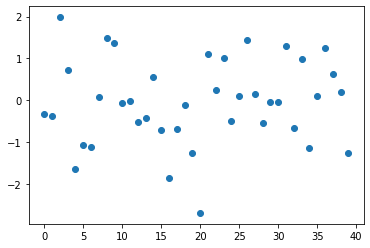

In [3]:
mu = 0
sigma = 1 

eps = np.random.normal(mu, sigma, size=N)

plt.scatter(np.arange(N),eps)

Соединим соседние точки линиями. Это полезно, когда в качестве счетчика выступает время

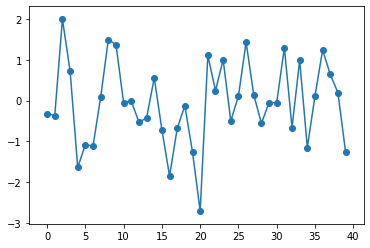

In [4]:
plt.plot(eps)
plt.scatter(np.arange(N),eps)

In [5]:
eps

array([-0.32053842, -0.36469351,  1.99410844,  0.73184454, -1.63610769,
       -1.07363623, -1.11419405,  0.08741799,  1.49429324,  1.37059577,
       -0.05703411, -0.01218208, -0.52652303, -0.42369395,  0.55974159,
       -0.71516133, -1.84645439, -0.67975146, -0.12368861, -1.26102318,
       -2.70121212,  1.10676022,  0.24408741,  1.00155061, -0.49535137,
        0.11211095,  1.43183619,  0.14202843, -0.55444413, -0.04981008,
       -0.0491162 ,  1.29616935, -0.65888712,  0.98224748, -1.14762947,
        0.11138645,  1.24196438,  0.63986034,  0.19269494, -1.25933442])

Сгенерируем данные для регрессии: добавим к линейной функции y=2+x белый шум eps. Диаграмма рассеяния показывает сильный линейный паттерн и в целом ведет себя хорошо

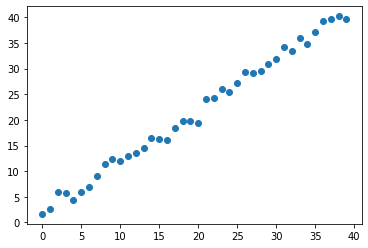

In [9]:
x = np.arange(N)
y = 2 + x + eps
plt.scatter(x,y)

Подготовим данные для обучения классической OLS регрессии. Все условия Гаусса-Маркова выполняются: признак детерминированный (числа от 1 до N), модель хорошая, шум белый.
Мы будем пользоваться не lstsq из linalg.numpy, а  конструктором LinearRegression() из библиотеки sklearn.
Как вы помните, lstsq работает на svd разложении и требует предварительной стандартизации данных в случае существенно разных шкал признаков.
LinearRegression() делает стандартизацию сама (впрочем, это можно настроить), однако следует иметь в виду, что алгоритм внутри нее зашит другой, тоже устойчивый к "плохим" данным. Как правило, реализации алгоритмов в sklearn направлены на то, чтобы функция работала быстро.
Реализация OLS через теоретическую формулу на практике не применяется из-за плохой вычислительной устойчивости.

In [10]:
# сначала переформатируем данные из одномерных массивов в двумерные, тк этого требует синтаксис LinearRegression() 
# при работе с реальными датасетами делать этого не нужно
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

[1.83569972] [[1.00543877]]


Одной из метрик качества модели является r2_score. Это так называемая доля объяснённой дисперсии. Она показывает, какую часть отклонений целевой переменной объясняет модель. Чем выше, тем лучше.

In [11]:
y_pred = linreg.predict(x)
r2_score(y,y_pred)

0.9925186300250072

Теперь давайте испортим немного модель, добавив гетероскедастичность

In [12]:
# создадим функцию, которая будет портить белый шум, добавляя в него неравные дисперсии.
# Кажое следующее значение шума будет в alpha раз выше предыдущего

def hetero_eps(alpha, eps):
    hetero_eps = np.zeros(len(eps))
    for i in range (0,len(eps)):
        hetero_eps[i] = (alpha**i) * eps[i]
    return hetero_eps

 Возьмем в качестве alpha 1.05, при этом каждое следующее отклонение будет примерно на 5% больше прыдущего
 На графике видно, что шум "расползается". Чем больше измерений мы возьмем, тем сильнее будет расплозаться шум, а с ним и весь тренд.
 В гомоскедастичном случае (для белого шума) чем больше измерений, тем точнее будет настроена регрессия, т.к. никакого расползания там нет

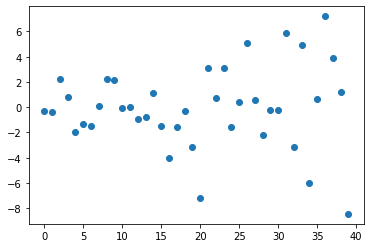

In [13]:
alpha = 1.05
heteps = hetero_eps(alpha,eps) # гетероскедастичный шум
plt.scatter(np.arange(N),heteps)

В модель y = 2 + x добавим гетероскедастичный шум и посмотрим, что будет с регрессией

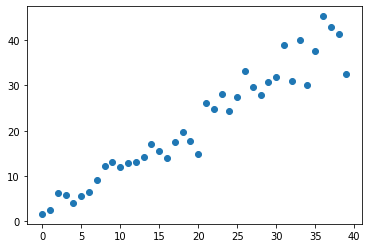

In [14]:
x = np.arange(N)
y = 2 + x + heteps
plt.scatter(x,y) # типичная картинка увеличения дисперсии

In [16]:
# сначала переформатируем данные из одномерных массивов в двумерные, т.к. этого требует синтаксис LinearRegression() 
# при работе с реальными датасетами делать этого не нужно
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
print(y.shape)
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

(40, 1)
[1.58681561] [[1.01897185]]


Как правило, коэффициенты модели с гетероскедастичностю сильнее отличаются от настоящих значений параметров 2 и 1 по сравнению с гомоскедастичным случаем.  
Пострадает и r2_score - модель с гетероскедатсичным шумом хуже объясняет изменения y. Прогнозы в такой модели тоже будут менее точные

In [17]:
y_pred = linreg.predict(x)
r2_score(y,y_pred)

0.931846945349523

Пример внизу показывает, что чем больше гетероскедастичность, тем хуже работает модель

In [18]:
x = np.arange(N)

# увеличим амлитуду шума в 4 раза

y = 2 + x + 4*heteps
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

# найдем оценки y
y_pred = linreg.predict(x)

# выведем r2_score
print(r2_score(y,y_pred))

[0.34726244] [[1.07588742]]
0.487884187392832


а вот что происходит с увеличением амплитуды шума в гомоскедатсичной модели:

In [19]:
x = np.arange(N)
# увеличим амлитуду шума в 4 раза
y = 2 + x + 4*eps
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

# найдем оценки y
y_pred = linreg.predict(x)

# выведем r2_score
print(r2_score(y,y_pred))

[1.3427989] [[1.02175509]]
0.8954290042124314


Как видите, intercept модели гуляет, но коэффициент при x оценивается довольно неплохо.
r2_score тоже ожидаемо падает, но не так сильно, как в гетероскедастичном случае.